In [6]:
path = r"/Users/constantinslioussarenko/PythonGitRepositories/MyoMap"
sys.path.append(path+"/epgpy")
sys.path.append(path+"/machines")
sys.path.append(path+"/mutools")
sys.path.append(path+"/dicomstack")
sys.path.append(path+"/mrf-sim")

#import matplotlib
#matplotlib.use("TkAgg")
from mrfsim import T1MRF
from image_series import *
from utils_mrf import *
import json
from finufft import nufft1d1,nufft1d2
from scipy import signal,interpolate
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
from movements import *
from dictoptimizers import *
from toy_model_keras import *
import tensorflow as tf
%matplotlib inline
## Random map simulation


class PerformancePlotCallback(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        self.x = x_test
        self.y = y_test

    def on_train_batch_end(self, epoch, logs=None):
        #print('Evaluating Model...')
        x = self.x.reshape(1,-1)
        #print(x.shape)
        pred = self.model.predict(x)
        Y_pred=optimizer.paramDict["output_scaler"].inverse_transform(pred.reshape(1,-1))

        global predictions

        predictions.append(Y_pred[0])

        #print("=====Parameters comparison===========")
        # print("Index : {}".format(i))
        # print("wT1 : {} vs {}".format(Y_pred[0][0], self.y[0]))
        # print("fT1 : {} vs {}".format(Y_pred[0][1], self.y[1]))
        # print("attB1 : {} vs {}".format(Y_pred[0][2], self.y[2]))
        # print("df : {} vs {}".format(Y_pred[0][3], self.y[3]))
        # print("ff : {} vs {}".format(Y_pred[0][4], self.y[4]))

        #print('Model Evaluation: ', self.model.evaluate(self.x_test))

In [2]:

useGPU=False

dictfile = "../mrf175.dict"
#dictfile = "mrf175_CS.dict"
dictfile = "../mrf175_SimReco2.dict"

with open("../mrf_sequence.json") as f:
    sequence_config = json.load(f)


seq = T1MRF(**sequence_config)

window = 8 #corresponds to nspoke by image
size=(256,256)

file_matlab_paramMap = "../data/Phantom1/paramMap.mat"

###### Building Map
#m = MapFromFile("TestPhantomV1",image_size=size,file=file_matlab_paramMap,rounding=True)

with open("../mrf_dictconf_SimReco2.json") as f:
    dict_config = json.load(f)

dict_config["ff"]=np.arange(0.,1.05,0.05)

window = 8 #corresponds to nspoke by image
region_size=16 #size of the regions with uniform values for params in pixel number (square regions)
size=(256,256)



file_matlab_paramMap = "../data/paramMap.mat"

###### Building Map
m = RandomMap("TestRandom",dict_config,image_size=size,region_size=region_size,mask_reduction_factor=1/4)

m.buildParamMap()

#m.plotParamMap(save=True)

##### Simulating Ref Images
m.build_ref_images(seq)

ntimesteps=175
nspoke=8
npoint = 2*m.images_series.shape[1]

radial_traj=Radial(total_nspokes=ntimesteps*nspoke,npoint=npoint)
kdata = m.generate_kdata(radial_traj,useGPU=useGPU)

volumes = simulate_radial_undersampled_images(kdata,radial_traj,m.image_size,density_adj=True,useGPU=useGPU)
mask = build_mask_single_image(kdata,radial_traj,m.image_size,useGPU=useGPU)#Not great - lets make both simulate_radial_.. and build_mask_single.. have kdata as input and call generate_kdata upstream


Building Param Map
Building Ref Images
Simulating Water Signal
Simulating Fat Signal
Build dictionary.
Building image series
Generating kdata


In [4]:
FF_list = list(np.arange(0., 1.05, 0.05))
keys, signal = read_mrf_dict(dictfile, FF_list)
Y_TF = np.array(keys)
real_signal = signal.real
imag_signal = signal.imag
X_TF = np.concatenate((real_signal, imag_signal), axis=1)


In [7]:
Y_TF[0]

array([5.5e+02, 3.0e+02, 3.0e-01, 6.0e-02, 0.0e+00])

(array([30780., 30780., 30780., 30780., 30780., 30780., 30780., 30780.,
        30780., 46170.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

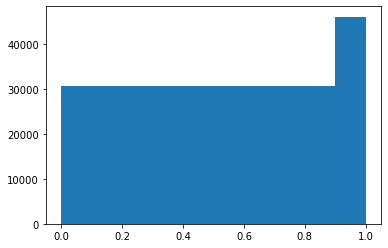

In [20]:
plt.hist(Y_TF[:,4])

In [13]:
df=pd.DataFrame(Y_TF)

In [16]:
df.describe()

,0,1,2,3,4
count,323190.000000,323190.0,323190.000000,3.231900e+05,323190.000000
mean,1127.631579,300.0,0.650000,-1.387822e-19,0.500000
std,353.100360,0.0,0.216025,3.872989e-02,0.302766
min,550.000000,300.0,0.300000,-6.000000e-02,0.000000
25%,830.000000,300.0,0.450000,-3.000000e-02,0.250000
50%,1115.000000,300.0,0.650000,-0.000000e+00,0.500000
75%,1400.000000,300.0,0.850000,3.000000e-02,0.750000
max,2000.000000,300.0,1.000000,6.000000e-02,1.000000


In [17]:

callbacks_list = []
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)


i=np.random.choice(X_TF.shape[0])
perf_callback = PerformancePlotCallback(X_TF[i],Y_TF[i])

predictions=[]

callbacks_list.append(tensorboard_callback)
callbacks_list.append(stop_early)
#callbacks_list.append(perf_callback)

2022-01-24 13:37:45.238369: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-24 13:37:45.238386: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-01-24 13:37:45.238422: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [18]:
def my_loss_fn(y_true, y_pred,weights):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`


In [19]:
def build_and_compile_model_simple(n_outputs,lr=0.01,loss="mean_squared_error",loss_weights=None,optimizer=tf.keras.optimizers.Adam):
    model = keras.Sequential([
        layers.Dense(1000, activation="relu", name="Dense_1"),
        layers.Dense(400, activation="relu", name="Dense_2"),
        #layers.Dense(50, activation="relu", name="Dense_3"),
        #layers.Dense(30, activation="relu", name="Dense_4"),
        layers.Dense(30, activation="relu", name="Dense_5"),
        layers.Dense(n_outputs,name="Dense_Out"),
    ])

    model.compile(loss=loss,
                  optimizer=optimizer(lr),loss_weights=loss_weights)
    return model

In [20]:

model = build_and_compile_model_simple
fitting_opt = {
"batch_size":256*4,"shuffle":True,
    "validation_split":0.2,
    "verbose":1, "epochs":300,"callbacks":callbacks_list

}



optimizer = ToyNN(model,fitting_opt,model_opt={"lr":0.1,"loss_weights":[1.,1.,10.,10.,10.]},mask=mask)
optimizer = ToyNN(model,fitting_opt,model_opt={"lr":0.01,"loss_weights":[1.,1.,10.,10.,10.]},mask=mask)
optimizer = ToyNN(model,fitting_opt,model_opt={"lr":0.01,"loss_weights":[1.,1.,10.,10.,10.],"optimizer":tf.keras.optimizers.SGD},mask=mask)

#optimizer = ToyNN(model,fitting_opt,model_opt={},mask=mask)



In [21]:
optimizer.fit_and_set(dictfile)

predictions=np.array(predictions)

(323190, 350)
(323190, 5)
5
Epoch 1/300
  8/253 [..............................] - ETA: 6s - loss: 0.1583 

2022-01-24 13:37:59.766385: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-24 13:37:59.766401: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-01-24 13:37:59.851480: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-24 13:37:59.856154: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-01-24 13:37:59.864949: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220124-133745/train/plugins/profile/2022_01_24_13_37_59
2022-01-24 13:37:59.865774: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20220124-133745/train/plugins/profile/2022_01_24_13_37_59/constantins-MacBook-Pro.local.trace.json.gz
2022-01-24 13:37:59.871758: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20220124-133

253/253 [==============================] - 4s 12ms/step - loss: 0.0178 - val_loss: 0.0248
Epoch 2/300
253/253 [==============================] - 3s 11ms/step - loss: 0.0050 - val_loss: 0.0191
Epoch 3/300
253/253 [==============================] - 3s 12ms/step - loss: 0.0035 - val_loss: 0.0161
Epoch 4/300
253/253 [==============================] - 3s 12ms/step - loss: 0.0029 - val_loss: 0.0142
Epoch 5/300
253/253 [==============================] - 3s 12ms/step - loss: 0.0025 - val_loss: 0.0130
Epoch 6/300
253/253 [==============================] - 3s 12ms/step - loss: 0.0022 - val_loss: 0.0123
Epoch 7/300
253/253 [==============================] - 3s 12ms/step - loss: 0.0021 - val_loss: 0.0116
Epoch 8/300
253/253 [==============================] - 3s 12ms/step - loss: 0.0019 - val_loss: 0.0112
Epoch 9/300
253/253 [==============================] - 3s 12ms/step - loss: 0.0018 - val_loss: 0.0105
Epoch 10/300
253/253 [==============================] - 3s 12ms/step - loss: 0.0017 - val_loss

253/253 [==============================] - 3s 13ms/step - loss: 7.7393e-04 - val_loss: 0.0058
Epoch 80/300
253/253 [==============================] - 3s 13ms/step - loss: 7.7102e-04 - val_loss: 0.0057
Epoch 81/300
253/253 [==============================] - 3s 12ms/step - loss: 7.6813e-04 - val_loss: 0.0058
Epoch 82/300
253/253 [==============================] - 3s 12ms/step - loss: 7.6543e-04 - val_loss: 0.0057
Epoch 83/300
253/253 [==============================] - 3s 13ms/step - loss: 7.6249e-04 - val_loss: 0.0057
Epoch 84/300
253/253 [==============================] - 3s 12ms/step - loss: 7.5964e-04 - val_loss: 0.0056
Epoch 85/300
253/253 [==============================] - 3s 12ms/step - loss: 7.5706e-04 - val_loss: 0.0056
Epoch 86/300
253/253 [==============================] - 3s 13ms/step - loss: 7.5457e-04 - val_loss: 0.0055
Epoch 87/300
253/253 [==============================] - 3s 13ms/step - loss: 7.5181e-04 - val_loss: 0.0056
Epoch 88/300
253/253 [============================

253/253 [==============================] - 3s 13ms/step - loss: 6.4119e-04 - val_loss: 0.0051
Epoch 156/300
253/253 [==============================] - 3s 13ms/step - loss: 6.4014e-04 - val_loss: 0.0050
Epoch 157/300
253/253 [==============================] - 3s 13ms/step - loss: 6.3901e-04 - val_loss: 0.0051
Epoch 158/300
253/253 [==============================] - 4s 14ms/step - loss: 6.3812e-04 - val_loss: 0.0050
Epoch 159/300
253/253 [==============================] - 3s 14ms/step - loss: 6.3689e-04 - val_loss: 0.0051
Epoch 160/300
253/253 [==============================] - 3s 13ms/step - loss: 6.3591e-04 - val_loss: 0.0049
Epoch 161/300
253/253 [==============================] - 4s 16ms/step - loss: 6.3485e-04 - val_loss: 0.0050
Epoch 162/300
253/253 [==============================] - 3s 13ms/step - loss: 6.3367e-04 - val_loss: 0.0049
Epoch 163/300
253/253 [==============================] - 3s 13ms/step - loss: 6.3269e-04 - val_loss: 0.0049
Epoch 164/300
253/253 [===================

Epoch 231/300
253/253 [==============================] - 3s 13ms/step - loss: 5.7685e-04 - val_loss: 0.0047
Epoch 232/300
253/253 [==============================] - 3s 13ms/step - loss: 5.7622e-04 - val_loss: 0.0047
Epoch 233/300
253/253 [==============================] - 3s 13ms/step - loss: 5.7567e-04 - val_loss: 0.0046
Epoch 234/300
253/253 [==============================] - 3s 13ms/step - loss: 5.7482e-04 - val_loss: 0.0045
Epoch 235/300
253/253 [==============================] - 3s 13ms/step - loss: 5.7425e-04 - val_loss: 0.0046
Epoch 236/300
253/253 [==============================] - 3s 13ms/step - loss: 5.7361e-04 - val_loss: 0.0046
Epoch 237/300
253/253 [==============================] - 3s 13ms/step - loss: 5.7298e-04 - val_loss: 0.0047
Epoch 238/300
253/253 [==============================] - 3s 13ms/step - loss: 5.7245e-04 - val_loss: 0.0045
Epoch 239/300
253/253 [==============================] - 3s 13ms/step - loss: 5.7183e-04 - val_loss: 0.0046
Epoch 240/300
253/253 [=====

In [27]:
scaled_input=optimizer.paramDict["input_scaler"].transform(X_TF)

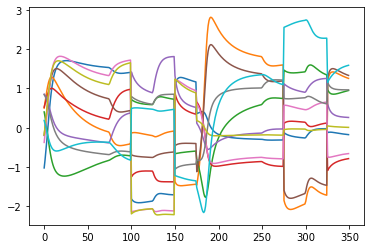

In [31]:
plt.plot(scaled_input[np.random.choice(list(range(scaled_input.shape[0])),10)].T)

In [36]:
scaled_input.mean(axis=0)

array([ 4.94538309e-14,  6.68423460e-14,  5.18119275e-14, -5.12812039e-14,
        3.32630692e-14, -2.41764081e-14, -1.00030342e-14,  2.55739790e-14,
       -3.44522854e-14,  6.34902055e-15, -1.17870722e-15,  1.36832846e-14,
        5.13394965e-15,  1.27240717e-15,  5.25277880e-15, -7.17212937e-15,
        5.04768623e-16,  2.49530263e-14,  5.26478414e-15, -2.25938201e-14,
        3.06724650e-14, -4.42785131e-14,  1.22459692e-14,  4.80198208e-14,
        3.23845217e-14,  2.18687505e-14, -8.22842281e-14, -2.85994873e-14,
       -2.01354265e-14, -1.47365891e-14, -2.70504729e-15,  9.64644305e-15,
       -2.45332116e-15, -4.41654490e-14, -2.77360156e-14,  3.71320496e-15,
       -8.11259686e-14,  1.46079765e-14,  7.74798737e-14,  1.88977623e-14,
       -7.73629387e-14,  3.90865560e-16, -1.00416131e-13, -4.30617721e-15,
       -1.53269698e-14,  2.21401480e-14,  1.18291019e-13,  6.89355301e-14,
        2.71843351e-14,  1.10394927e-13,  6.95443098e-15,  1.11230529e-13,
        2.67940336e-14,  

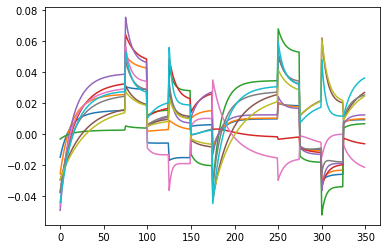

In [32]:
plt.plot(X_TF[np.random.choice(list(range(X_TF.shape[0])),10)].T)

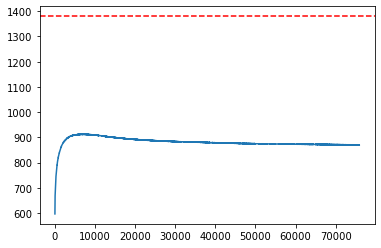

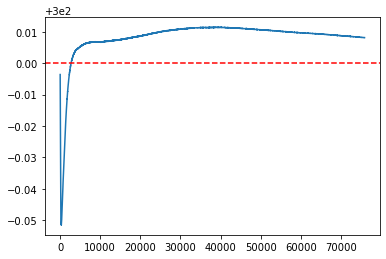

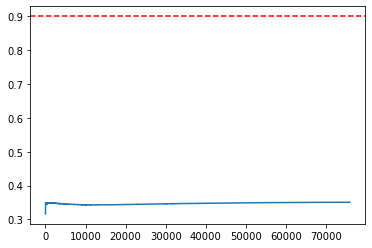

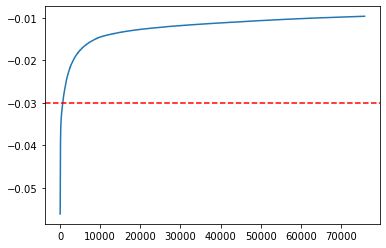

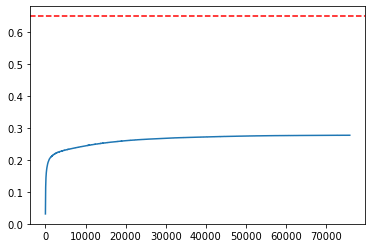

In [13]:
for j in range(Y_TF.shape[1]):
    plt.figure()
    plt.plot(predictions[10:,j])
    plt.axhline(y=Y_TF[i,j],c="r",linestyle="dashed")


In [22]:
all_maps_adj=optimizer.search_patterns(dictfile,volumes)



(16384, 350)


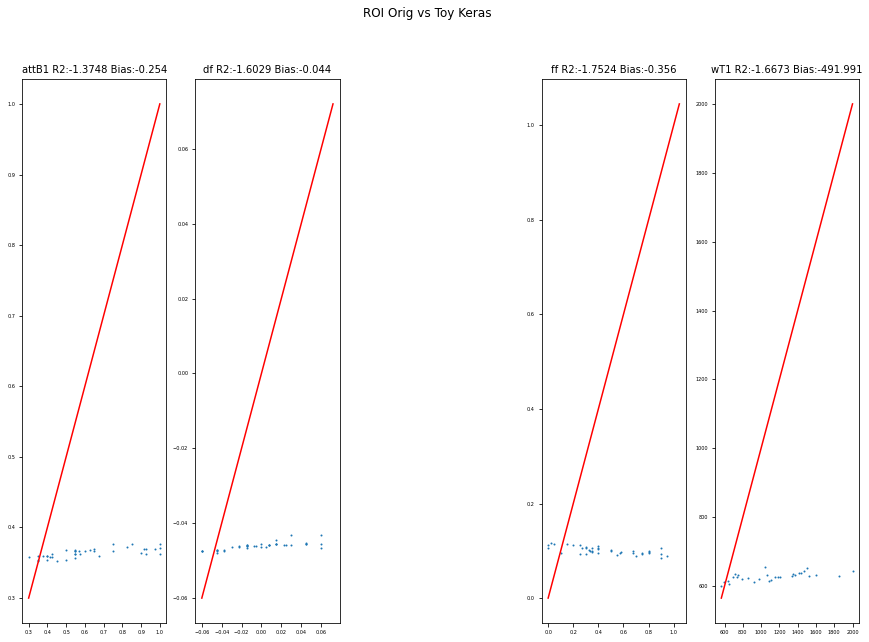

In [23]:

maskROI=buildROImask(m.paramMap)
regression_paramMaps_ROI(m.paramMap, all_maps_adj[0][0], m.mask > 0, all_maps_adj[0][1] > 0,maskROI=maskROI,
                             title="ROI Orig vs Toy Keras", proj_on_mask1=True, adj_wT1=True, fat_threshold=0.7)


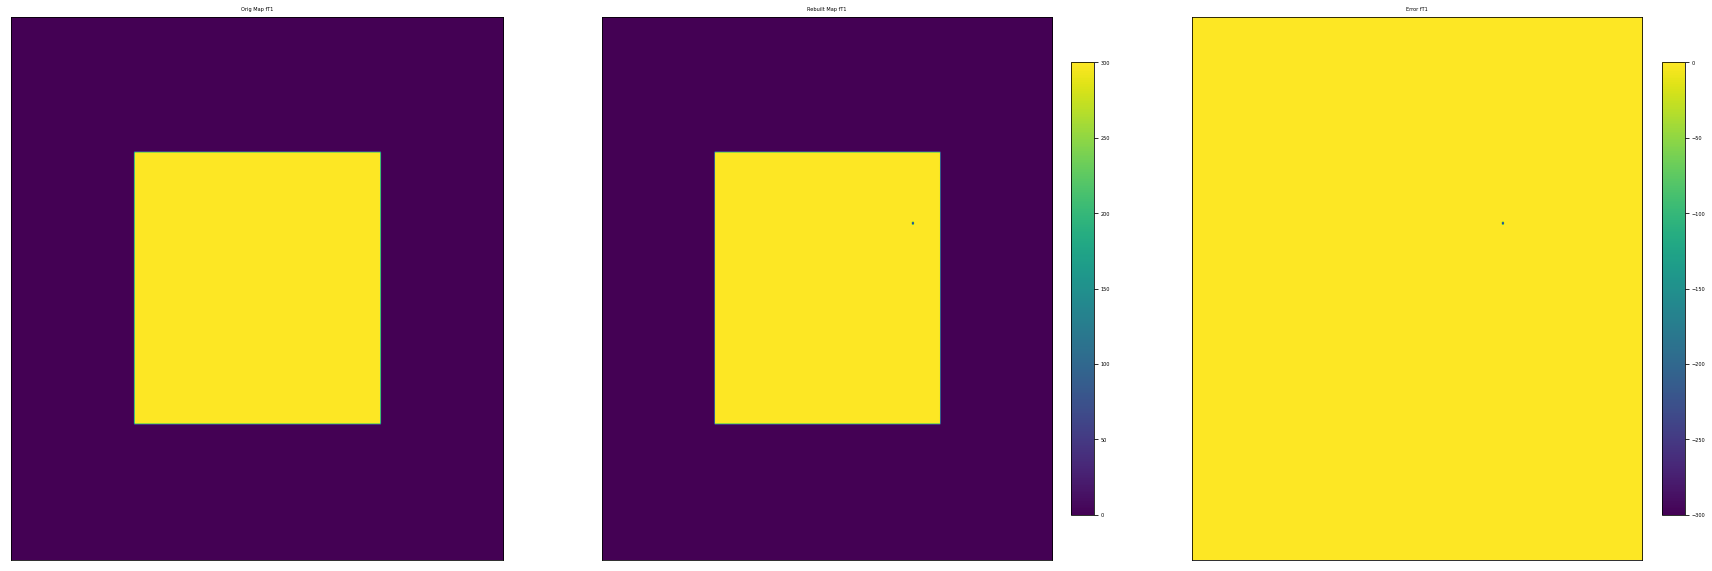

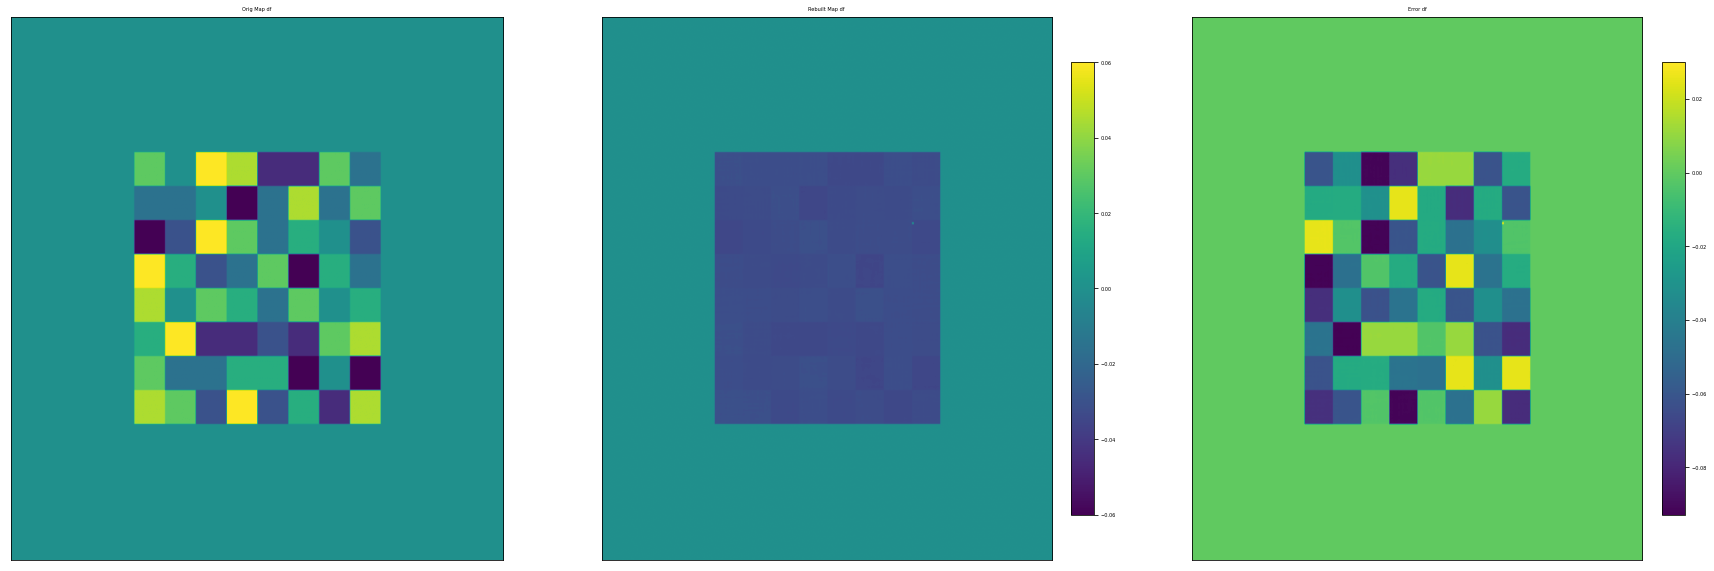

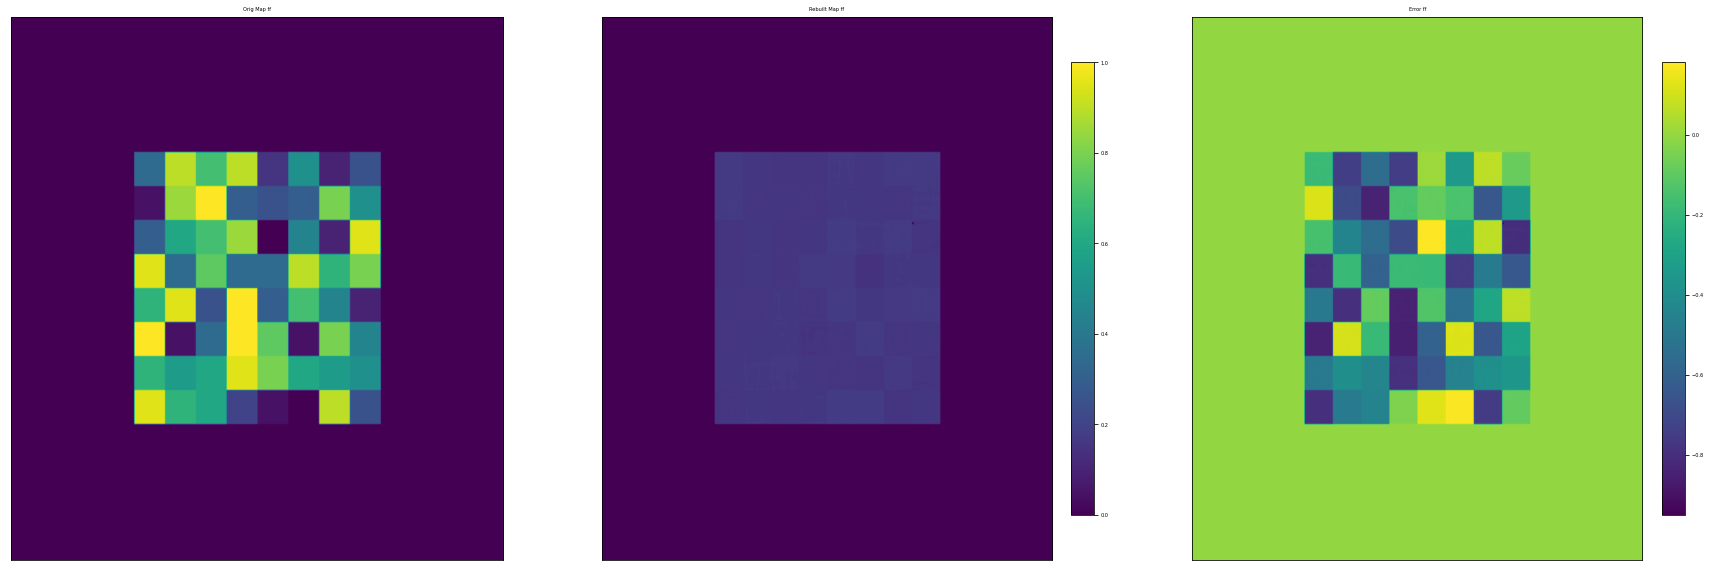

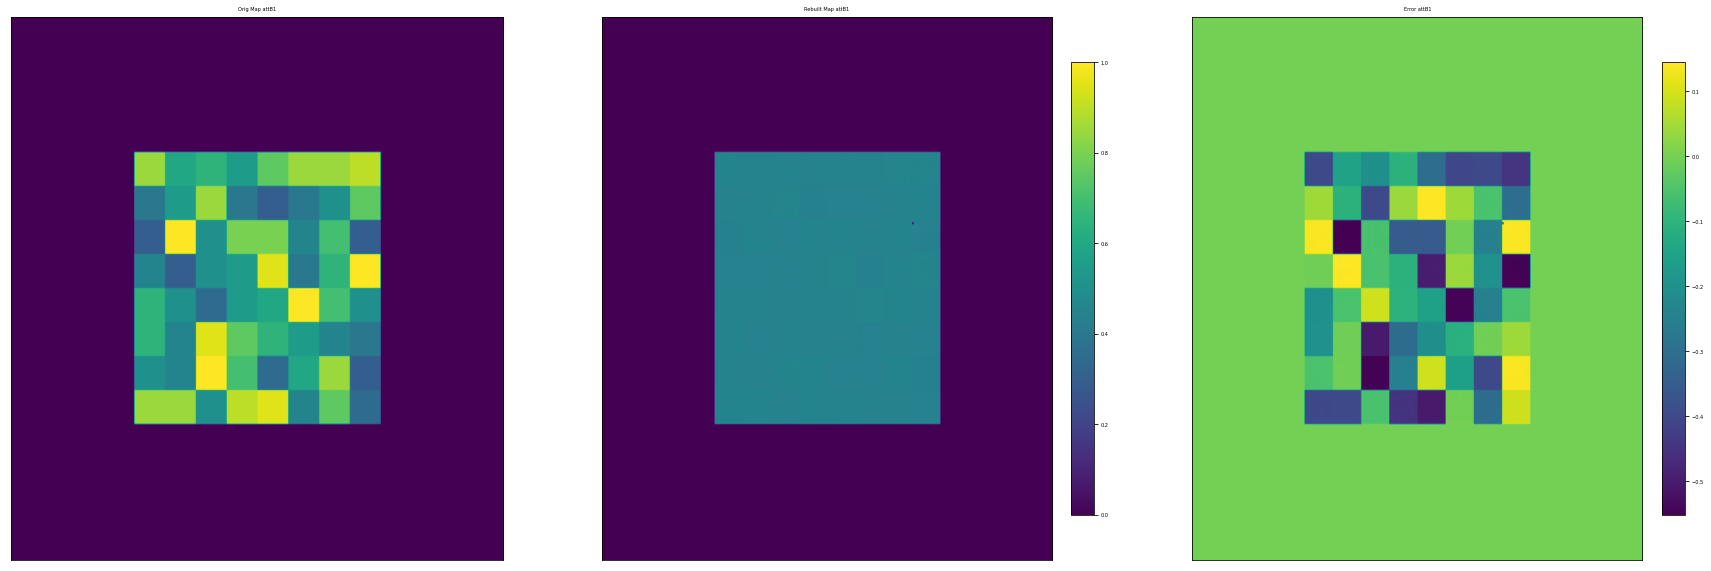

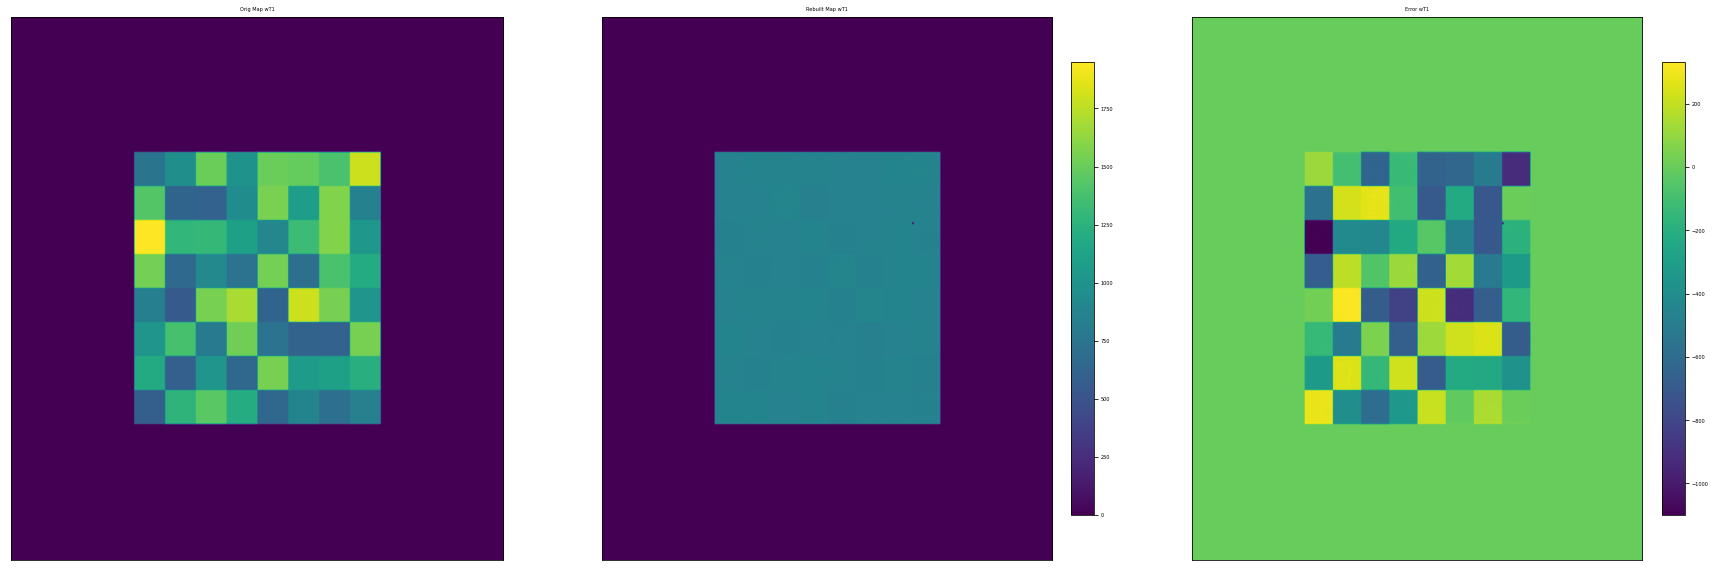

In [45]:

compare_paramMaps(m.paramMap, all_maps_adj[0][0], m.mask > 0, all_maps_adj[0][1] > 0,adj_wT1=True,fat_threshold=0.7,proj_on_mask1=True)